In [1]:
import sys

sys.path.append('..')

In [2]:
import numpy as np

maturity = 5.

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

In [3]:
from finance.discountfactor import ConstantRateDiscountFactor 

r = 0.02
discount = ConstantRateDiscountFactor(r)

In [4]:
hurdle_rate = 0.1

In [5]:
def compute_varrho_ccp(loss_dfr, cva_t0_dfr, cva_t1_dfr, t0_, t1_, incl_cva):
    rho = loss_dfr.sum(axis=1) 
    
    if incl_cva:
        rho += discount(t1_) * cva_t1_dfr.sum(axis=1)
        rho -= discount(t0_) * cva_t0_dfr.sum(axis=1)
    
    return rho

In [6]:
import pandas as pd
import os

loss_path = './res/aggregated/loss_1y_ahead/'
cva_path = './res/aggregated/cva_ccp/'

df_times_path = './res/aggregated/default_times.csv'

In [7]:
df_times = pd.read_csv(df_times_path, header=0, index_col=0)

trans_df_times = df_times.transpose()

In [8]:
trans_df_times2y = trans_df_times[(2. <= trans_df_times) & (trans_df_times < 3.)]
trans_df_times2y = trans_df_times2y.dropna(how='all')

trans_df_times2y.head()

,17,9,29,26,50,4,5,13,64
1,NaN,NaN,2.977778,2.408333,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,2.375000,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,2.613889,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,2.061111,2.563889,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,2.244444,NaN,NaN,NaN,NaN,NaN


In [9]:
def compute_1y_ahead_varrho_ccp(times_cva_, shifted_times_cva_, incl_cva=True):
    varrho_ccp = dict()
    
    for t0_, t1_ in zip(times_cva_, shifted_times_cva_):
        cur_loss_int = "[%.2f, %.2f]" % (t0_, t1_)
        loss_path_ = os.path.join(loss_path, 'loss_%s.csv' % cur_loss_int)
        loss_ahead = pd.read_csv(loss_path_, index_col=0, header=0)
    
        cur_t0 = "%.2f" % t0_
        cva_t0_path = os.path.join(cva_path, 'cva_%s.csv' % cur_t0)
        cva_t0 = pd.read_csv(cva_t0_path, index_col=0, header=0)
    
        cur_t1 = "%.2f" % t1_
        cva_t1_path = os.path.join(cva_path, 'cva_%s.csv' % cur_t1)
        cva_t1 = pd.read_csv(cva_t1_path, index_col=0, header=0)
    
        col_names = ['all', 17, 9, 29, 26, 50, 4, 5, 13, 64]
        varrho_ccp_t0_t1 = {}
    
        for col in col_names:
            if col == 'all':
                varrho_ser = compute_varrho_ccp(loss_ahead, cva_t0, cva_t1, t0_, t1_, incl_cva)
            else:
                col = unicode(col)
                loss__ = loss_ahead.drop(col, 1)
                cva_t0__ = cva_t0.drop(col, 1)
                cva_t1__ = cva_t1.drop(col, 1)
            
                varrho_ser = compute_varrho_ccp(loss__, cva_t0__, cva_t1__, t0_, t1_, incl_cva)    
    
            varrho_ccp_t0_t1[col] = varrho_ser
        
        varrho_ccp[cur_loss_int] = pd.DataFrame(varrho_ccp_t0_t1)
    
    return varrho_ccp

In [10]:
varrho_ccp = compute_1y_ahead_varrho_ccp(times_cva, shifted_times_cva, incl_cva=True)
varrho_ccp_time = pd.DataFrame({key: value['all'] for (key, value) in zip(times_cva, varrho_ccp.values())})

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

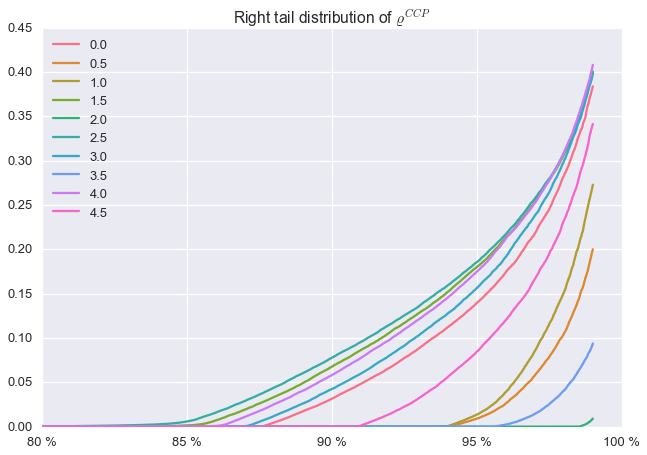

In [42]:
from matplotlib.ticker import FuncFormatter

palette = sns.color_palette('husl', len(varrho_ccp_time.columns))
sns.set_palette(palette)

alpha = 0.8
index = int(alpha * len(varrho_ccp_time))

alpha2 = 0.99
index_sup = int(alpha2 * len(varrho_ccp_time))

for t in varrho_ccp_time.columns:
    crt_varrho = varrho_ccp_time[t]
    crt_varrho = crt_varrho.sort_values(inplace=False)
    crt_varrho = crt_varrho.reset_index(drop=True)
    
    #crt_varrho.reset_index(drop=True).plot(label=t)
        
    plt.plot(crt_varrho.index[index:index_sup], crt_varrho.values[index:index_sup], label=t)
    #print crt_varrho.index.values[index:]
    #print crt_varrho.values[index:]
    
formatter_prob = FuncFormatter(lambda y, pos: "%.0f %%" % (y / 1000.))
plt.gca().xaxis.set_major_formatter(formatter_prob)
    
plt.title(r'Right tail distribution of $\varrho^{CCP}$')
plt.legend(loc='best')
plt.show()